# South Africa

CAMS PM2.5: Original resolution: 80km x 80km. Improved resolution: 10km x 10km.



In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   load_list_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [4]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = True

## Model VALIDATION

Create target grid for the AOI (10 km)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


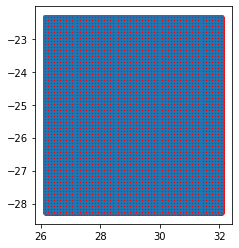

In [23]:
# Prepare grid
bounds_down = list(cams_train_eop.bbox)
res_down = bbox_to_dimensions(cams_train_eop.bbox, 10000)
xres_down = (bounds_down[2]-bounds_down[0])/res_down[0]
yres_down = (bounds_down[3]-bounds_down[1])/res_down[1]

bounds_down = geometry.box(bounds_down[0], bounds_down[1], bounds_down[2], bounds_down[3])
bounds_down = gpd.GeoDataFrame({"id":1,"geometry":[bounds_down]}, crs="EPSG:4326")
CAMS_grid_down = polygrid(bounds_down, xres_down, yres_down, 4326)
CAMS_centroids_down = gpd.GeoDataFrame(geometry= CAMS_grid_down.centroid)

del cams_train_eop

# Show it
p = CAMS_grid_down.boundary.plot()
CAMS_centroids_down.plot(ax=p, color='red')
plt.show()


### Extract predictor data at CAMS 10km

#### Prepare DEM with 10km CAMS for validtion process

In [64]:
no_data_value = 128
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                            filename='DEM_1km.tif',
                           no_data_value=no_data_value)

## FILTER NO VALID DATA BEFORE STARTING
dem_train_eop.data_timeless['DEM'][dem_train_eop.data_timeless['DEM'] == no_data_value] = np.nan

# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0]
dem_grid_10km = CAMS_grid_down
zstats = zonal_stats(dem_grid_10km, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
    
dem_grid_10km['elevation'] = vals

In [74]:
# Now we can rasterize
minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
sizey = round((maxy-miny)/yres_down)
sizex = round((maxx-minx)/xres_down)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid_10km.geometry, dem_grid_10km['elevation']))

dem10km = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)

export_geotiff(str(dem_train_dir) + '/DEM_CAMS_Val.tif', dem10km, transform, 4326)

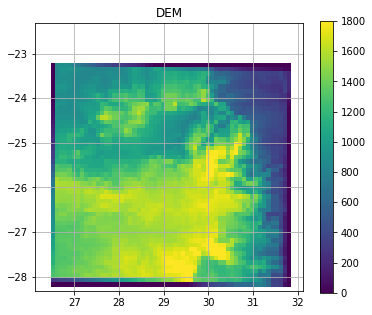

In [75]:
# Read and visualize
dem_val_dir = DATA_DIR/AOIS[0]/'DEM'
dem_val_eop = load_tiffs(datapath=dem_val_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                           filename='DEM_CAMS_Val.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_val_eop,
                  feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                  time_idx=None,
                  vmin=0, vmax=1800)
#pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);

#### Prepare ERA5 with 10km CAMS

In [37]:
## Paths of validation ERA5 
VAL_DATA_DIR = Path("validation_dataset_south_africa")
era5_val_dir = VAL_DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_val_dir))
resampled_val_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/resampled_era5_10km'

In [32]:

## Create direction for resampled ERA5
resampled_val_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/resampled_era5_10km'
if not os.path.isdir(resampled_val_era5_location):
    os.makedirs(resampled_val_era5_location)
    for i in era5_products:
        os.mkdir(resampled_val_era5_location + '/' + i)  

## Upscale the validation ERA5

target_size = bbox_to_dimensions(cams_train_eop.bbox, 10000)
for i in era5_products:
    for j in glob.glob(str(era5_val_dir) + '/' + i + '/*.tif'):
        path_in = j
        path_out = re.sub('era5', 'resampled_era5_10km', path_in)
        upscale_tiff(path_in, path_out, target_size)




In [77]:
## Select ERA5 data with the same dates of submission

days = [2150,2153,2161,2170,2178,2180, 2186,2190,2196,2200]
hour = 'h12'

files_name = []
for era5_p in era5_products:
    era5_product_paths = []
    for day in days:
        era5_product_path = glob.glob(str(resampled_val_era5_location) +'/' +era5_p + '/' +  f'*day{day}_{hour}.tif')[0:2208]
        era5_product_paths = era5_product_paths + era5_product_path
        filenames = [path.replace(str(resampled_val_era5_location) + f'/{era5_p}/','') for path in era5_product_paths]
        
    files_name.append(filenames)

#files_name


In [85]:
## Load Selected ERA5

# Load data
val_era5_eops = []
for file_names, era5_p in [(files_name[0], 'relative_humidity'),(files_name[1], 'specific_rain_water_content'),(files_name[2], 'wind_u'),(files_name[3], 'wind_v')]:
    val_era5_eop = load_list_tiffs(Path(resampled_val_era5_location)/era5_p, 
                               (FeatureType.DATA,era5_p), 
                                offset=OFFSET,
                                filename = file_names,
                                image_dtype=np.float32,
                                data_source='era5')
    val_era5_eops.append(val_era5_eop)



# Merge into one EOPS
val_era5_eop = EOPatch(data={'relative_humidity': val_era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': val_era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': val_era5_eops[2].data['wind_u'],
                        'wind_v': val_era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': val_era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': val_era5_eops[1].meta_info['Names'],
                             'Names_wind_u': val_era5_eops[2].meta_info['Names'],
                             'Names_wind_v': val_era5_eops[3].meta_info['Names']},
                     timestamp=val_era5_eops[0].timestamp,
                     bbox=val_era5_eops[0].bbox)
del val_era5_eops
#val_era5_eop


In [87]:
## Filter NO VALID DATA OF ERA5
NO_DATA_VALUE = -32767

val_era5_eop.data['relative_humidity'][val_era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['specific_rain_water_content'][val_era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['wind_u'][val_era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
val_era5_eop.data['wind_v'][val_era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

In [89]:
# Perform zonal statistics - ERA5 products per CAMS pixel
# Rastrize the new CAMS zonal stats and save them on disk


## location of exported tiff (ERA5 matching CAMS grid)
val_rastrize_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/val_rastrize_era5_cams'
if not os.path.isdir(val_rastrize_era5_location):
    os.makedirs(val_rastrize_era5_location)
    for i in era5_products:
        os.mkdir(val_rastrize_era5_location + '/' + i)
        
for index, era5p in enumerate(era5_products):
    tiffs = sorted(files_name[index])
    i=0
    for tiff in tiffs:
        for era5_path in glob.glob(str(resampled_val_era5_location) + '/' + era5p + '/' +  tiff):
            src = rio.open(era5_path)
            affine = src.transform
            array = val_era5_eop.data[era5p][i]
            array = array[:, :, 0]
            era5_grid = CAMS_grid_down
            era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)

            vals = []
            for index, value in enumerate(era5_stats):
                vals.append(value['mean'])

            era5_grid[era5p] = vals

            # rasterize
            minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
            sizey = round((maxy-miny)/yres_down)
            sizex = round((maxx-minx)/xres_down)

            transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
            shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5p]))
            era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
            tiffname = val_era5_eop.meta_info['Names_'+ era5p][i]
            export_geotiff(str(val_rastrize_era5_location) + '/' +era5p + '/'+ tiffname, era5, transform, 4326)
            
            i+=1

#del val_era5_eop

## Prediction

In [17]:
bbox_sa = gpd.read_file('AOIs_bboxes/South_Africa/South_Africa_test.shp')

In [18]:
cams_pm25_test_dir = Path('validation_dataset_south_africa/South_Africa/CAMS/PM2_5')
dates_sa_pm25 = pd.read_csv('submission_date/SA-date-PM25.txt')
dates_sa_pm25

,Day,time
0,2150,h12
1,2153,h12
2,2161,h12
3,2170,h12
4,2178,h12
5,2180,h12
6,2186,h12
7,2190,h12
8,2196,h12
9,2200,h12


In [19]:
## Prepare the test images
input_filenames = []
for index in dates_sa_pm25.index:
    day, time = dates_sa_pm25.iloc[index]
    input_filename = f'CAMS_PM2_5_day{day}_{time.split(" ")[-1]}.tif'
    input_filenames.append(input_filename)

input_filenames

['CAMS_PM2_5_day2150_h12.tif',
 'CAMS_PM2_5_day2153_h12.tif',
 'CAMS_PM2_5_day2161_h12.tif',
 'CAMS_PM2_5_day2170_h12.tif',
 'CAMS_PM2_5_day2178_h12.tif',
 'CAMS_PM2_5_day2180_h12.tif',
 'CAMS_PM2_5_day2186_h12.tif',
 'CAMS_PM2_5_day2190_h12.tif',
 'CAMS_PM2_5_day2196_h12.tif',
 'CAMS_PM2_5_day2200_h12.tif']

#### Extract DEM
Note: 0 values of extracted DEM

In [24]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
raster_path = [(str(dem_train_dir) + '/DEM_CAMS_Val.tif')]
dem_val_df = extract_points_from_raster(CAMS_centroids_down, raster_path, 'DEM')
dem_val_df = pd.concat(dem_val_df)
dem_val_df = dem_val_df.dropna()
dem_val_df = dem_val_df.drop('raster', 1)  


In [26]:
## Create submission file

submission_dir = Path('test-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)
            
visulize_dir = Path('test-visulize')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(visulize_dir/aoi/product):
            os.makedirs(visulize_dir/aoi/product)

In [27]:
# Extract val ERA5

## We can put this function in the utility file
def extract_val_era5(era5_p,tiff_name,cams_centroids,path):
    era5_path = [(str(path) + '/'+ era5_p + '/' +tiff_name + '.tif')]
    era5_df = extract_points_from_raster(cams_centroids, era5_path, era5_p)
    era5_df = pd.concat(era5_df)
    era5_df = era5_df.dropna()
    return era5_df



#### Predict UPSCALED CAMS VALUES 

In [32]:
## Direction in case not doing the previous steps
VAL_DATA_DIR = Path("validation_dataset_south_africa")
val_rastrize_era5_location = str(VAL_DATA_DIR/AOIS[0])+'/val_rastrize_era5_cams'

bbox_sa.to_crs(epsg=4326, inplace=True)
bbox_sa.to_file('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', driver='ESRI Shapefile')

test_df = dem_val_df

for input_filename in input_filenames:
    test_df['day']=np.nan
    test_df['hour']=np.nan
    test_df['dayhour']=""
    
    for i in range(test_df.shape[0]):
        tiff_name = input_filename
        day, hour = tiff_name.split('_day')[-1].split('_')
        test_df.iat[i,test_df.columns.get_loc('day')] = day
        test_df.iat[i,test_df.columns.get_loc('hour')] = hour[1:3]
        test_df.iat[i,test_df.columns.get_loc('dayhour')] = str(day)+str(hour[1:3])
        
    ##Extract ERA5 data for the same date and hour    
    test_rh_df = extract_val_era5('relative_humidity', f'ERA5_rh_day{day}_h{hour[1:3]}', CAMS_centroids_down, val_rastrize_era5_location)
    test_srwc_df = extract_val_era5('specific_rain_water_content', f'ERA5_srwc_day{day}_h{hour[1:3]}' ,CAMS_centroids_down, val_rastrize_era5_location)
    test_u_df = extract_val_era5('wind_u', f'ERA5_u_day{day}_h{hour[1:3]}', CAMS_centroids_down, val_rastrize_era5_location)
    test_v_df = extract_val_era5('wind_v', f'ERA5_v_day{day}_h{hour[1:3]}' ,CAMS_centroids_down, val_rastrize_era5_location)
    
    
    ## Join ERA5 & DEM data with (location)
    test_X = pd.merge(test_rh_df, test_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_srwc_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_u_df, on=['lon', 'lat'], how='inner')
    test_X = pd.merge(test_X, test_v_df, on=['lon', 'lat'], how='inner')
    

    # X inputs
    test_X = np.array(test_X.drop(['day','dayhour','raster_x','raster_y'], axis=1))
    
    ## PREDICTION
    predicted_CAMS = rf.predict(test_X)
    
    #test_df['predicted_CAMS'] = predicted_CAMS
    
    ## rastrize
    minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
    sizey = round((maxy-miny)/yres_down)
    sizex = round((maxx-minx)/xres_down)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(CAMS_grid_down.geometry, predicted_CAMS))
    upscaled_PM_2_5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    
    ## export for prediction
    export_geotiff(str(submission_dir) + '/South_Africa/PM2.5/'+f'{day}_PM25_South_Africa.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif')
    
    ## export them for visualization 
    export_geotiff(str(visulize_dir) + '/South_Africa/PM2.5/'+f'CAMS_PM25_day{day}_{hour}.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('AOIs_bboxes/WGS84/sa-bbox-wgs84.shp', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif')
    
    
    

In [33]:
## load upscaled CAMS
upscaled_cams_dir = Path('test-visulize/South_Africa/PM2.5')
upscaled_img = load_tiffs(upscaled_cams_dir,
                          (FeatureType.DATA, 'PM2_5'),
                          offset=OFFSET,
                          data_source='cams')


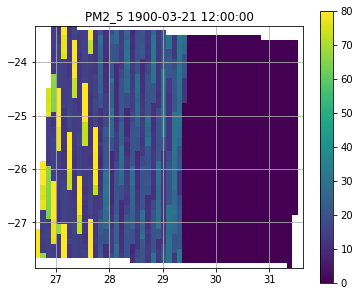

In [35]:

time_idx = 5

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_img,
                  feature=(FeatureType.DATA, 'PM2_5'),
                  time_idx=time_idx,
                  vmin=0, vmax=80)
#pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);

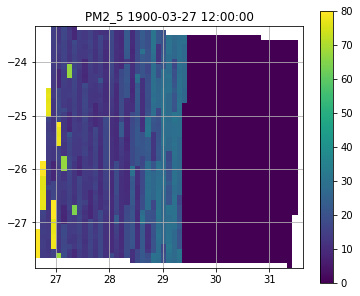

In [36]:

time_idx = 6

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_img,
                  feature=(FeatureType.DATA, 'PM2_5'),
                  time_idx=time_idx,
                  vmin=0, vmax=80)
#pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);